# Value Clustering for OP (Before Covid Effects)

In [2]:
# basic
import os
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

sns.set_style("whitegrid")
# sns.color_palette('bright')
# sns.set_palette('dark')

In [3]:
df = pd.read_excel('OP_Covid_cleaned.xlsx')

In [4]:
df.head()

,Outlet Number,Name,Sub Trade Channel,Segment,Sales Center,Net Revenue
0,9655807,FIRINTAS DIS HASTANE,BAKERY-CAFE,SILVER,50: BURSA SCM,100.00
1,20037159,FAWORI PLAYSTATION (G.MH,INTERNET CAFE / GAME,SILVER,30: ANKARA SCM,100.00
2,311489,MANAVGAT BELD.GENCLIK MERK.KUL,SOCIAL CLUB/COUNTRY,SILVER,20: ANTALYA SCM,100.01
3,3300414,MUSTAFA YILDIZ,KIOSK/FOOD/CANTEEN,BRONZE,60: MERSIN SCM,100.14
4,9556367,NURCAN ESEN,MODERN FAST FOOD RES,SILVER,50: BURSA SCM,100.24


In [16]:
df.OutletNumber.nunique()

159201

In [6]:
df[df.duplicated()]

,Outlet Number,Name,Sub Trade Channel,Segment,Sales Center,Net Revenue


## EDA

In [8]:
# deleting white spaces
df.columns = df.columns.str.replace(' ', '')

In [9]:
df['OutletNumber'] = df['OutletNumber'].astype(object)

In [10]:
print("Total number of Outlets: ", df.OutletNumber.nunique())

Total number of Outlets:  159201


### Revenue Dist.

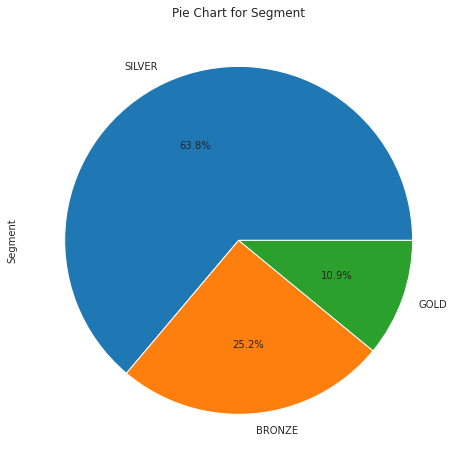

In [33]:
df['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Pie Chart for Segment')
plt.show()

In [34]:
df.Segment.value_counts()

SILVER    101637
BRONZE     40134
GOLD       17430
Name: Segment, dtype: int64

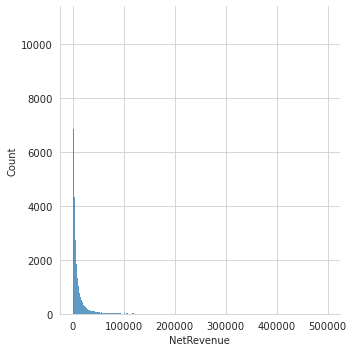

In [35]:
sns.displot(df['NetRevenue'])

In [36]:
df['log_rev'] = np.log(df['NetRevenue'])

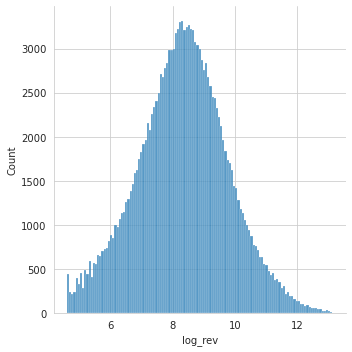

In [37]:
# after normalization
sns.displot(df['log_rev'])

## Elbow Method

In [38]:
rev_model_data = df['log_rev']

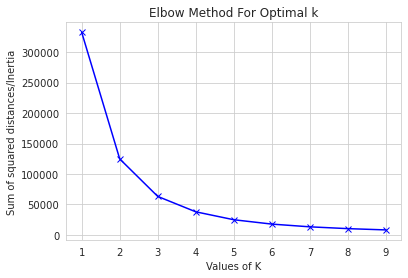

In [39]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_model_data.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [17]:
model = KMeans(n_clusters=4, random_state=42, max_iter=100000, init='random')

In [18]:
model.fit(rev_model_data.values.reshape(-1, 1))
preds = model.predict(rev_model_data.values.reshape(-1, 1))

NameError: name 'rev_model_data' is not defined

In [19]:
rev_model_data = pd.concat([rev_model_data, pd.DataFrame({'preds':preds}, index=rev_model_data.index)], axis=1)

NameError: name 'rev_model_data' is not defined

In [20]:
result = pd.merge(rev_model_data, df[['Segment', 'NetRevenue']], how='inner', left_index=True, right_index=True)
result['preds'] = result['preds'].astype('category')

NameError: name 'rev_model_data' is not defined

In [21]:
result.head(1)

NameError: name 'result' is not defined

In [22]:
sns.lmplot(x='log_rev', y='log_rev', data=result, hue='preds', fit_reg=False)

NameError: name 'result' is not defined

In [23]:
result['rank'] = result['preds'].apply(lambda x: 
                                      0 if x==2 # green
                                      else 1 if x==0 # blue
                                      else 2 if x==3 # red
                                      else 3) # green

NameError: name 'result' is not defined

In [47]:
result['rank'].value_counts()

2    54945
1    54498
0    26073
3    23685
Name: rank, dtype: int64

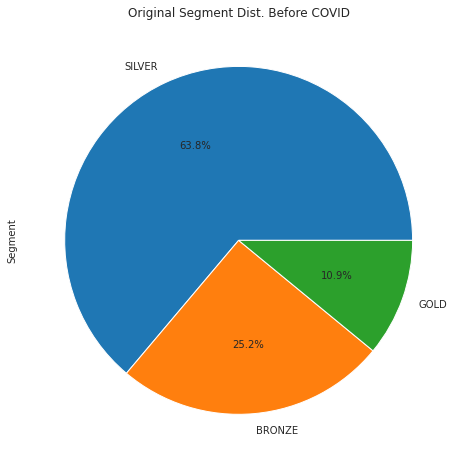

In [48]:
df["Segment"].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Original Segment Dist. Before COVID')
plt.show()

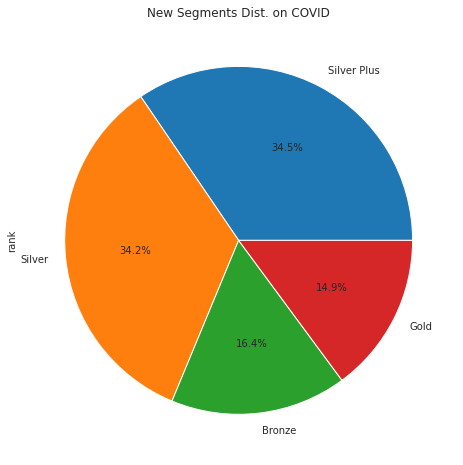

In [108]:
result["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('New Segments Dist. on COVID')
plt.show()

In [107]:
result["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts()

Silver Plus    54945
Silver         54498
Bronze         26073
Gold           23685
Name: rank, dtype: int64

## Decision Points

In [51]:
d = DecisionTreeClassifier(random_state=42)
d.fit(result['NetRevenue'].values.reshape(-1,1), result['rank'])
d_preds = d.predict(result['NetRevenue'].values.reshape(-1,1))
d_text = tree.export_text(d)
print(d_text)

|--- feature_0 <= 4272.61
|   |--- feature_0 <= 1002.64
|   |   |--- class: 0
|   |--- feature_0 >  1002.64
|   |   |--- class: 1
|--- feature_0 >  4272.61
|   |--- feature_0 <= 17748.03
|   |   |--- class: 2
|   |--- feature_0 >  17748.03
|   |   |--- class: 3



In [52]:
result.NetRevenue.describe()

count    159201.000000
mean      11560.904252
std       26326.169607
min         100.000000
25%        1606.580000
50%        4186.900000
75%       10531.760000
max      498629.700000
Name: NetRevenue, dtype: float64

## Comparison Matrix

In [54]:
df_new = pd.merge(df[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','log_rev']], 
                  result[['Segment', 'rank']], 
                  how='inner', left_index=True, right_index=True)

rank         0      1      2      3
Segment                            
BRONZE    9453  21124   9192    365
GOLD       413   1189   4384  11444
SILVER   16207  32185  41369  11876


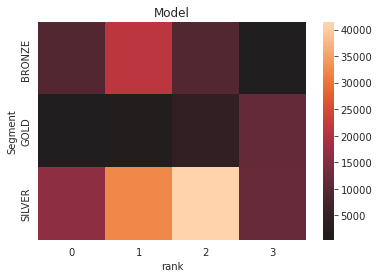

In [55]:
d1 = pd.pivot_table(data=df_new
              , index='Segment'
              , columns='rank'
              , values='OutletNumber'
              , aggfunc=np.size
              , fill_value=0).sort_index()

d1 = d1[sorted(d1.columns)]
print(d1)
sns.heatmap(d1, center=0).set_title('Model')
plt.show()

In [56]:
df_new.groupby('rank', as_index=False).agg({'NetRevenue':np.mean})

,rank,NetRevenue
0,1,2424.901272
1,3,51174.517258
2,0,520.581125
3,2,8785.398040


In [57]:
df_new.groupby('rank', as_index=False).agg({'NetRevenue':np.max})

,rank,NetRevenue
0,1,4272.47
1,3,498629.70
2,0,1002.60
3,2,17747.71


### Save as CSV

In [ ]:
#final_df = df_new[['OutletNumber','Name','OutletAddress2','SubTradeChannel','SalesCenter','NetRevenue','rank']]

In [ ]:
# ismi değiştir
#final_df.to_csv('results_clus4_20211005.csv', sep='|')

<h1><center>Regional Distribution</center></h1>

In [109]:
df.SalesCenter.unique()

array(['50: BURSA SCM', '30: ANKARA SCM', '20: ANTALYA SCM',
       '60: MERSIN SCM', '40: KARADENIZ SCM', '13: ISTANBUL COLD DRINK',
       '90: IZMIR SCM', '70: ELAZIG SCM', '12: ISTANBUL HOME CHANNE',
       '71: HOD', '65: AT WORK', '18: KEY CUSTOMER SC'], dtype=object)

In [60]:
# WEST
df_w = df.loc[df['SalesCenter'].isin(['13: ISTANBUL COLD DRINK',
                                      '50: BURSA SCM',
                                      '90: IZMIR SCM',
                                      '30: ANKARA SCM',
                                      '71: HOD',
                                      '20: ANTALYA SCM',
                                      '93: LAM HOTELS SCM',
                                      '12: ISTANBUL HOME CHANNE'
                                      '18: KEY CUSTOMER SC'])]

In [61]:
df_w = df_w.reset_index(drop=True)

In [114]:
print("Total number of Outlets: ", df_w.OutletNumber.nunique())

Total number of Outlets:  106530


In [63]:
# EAST
df_e = df.loc[df['SalesCenter'].isin(['70: ELAZIG SCM','60: MERSIN SCM','40: KARADENIZ SCM','65: AT WORK'])]

In [64]:
df_e = df_e.reset_index(drop=True)

In [115]:
print("Total number of Outlets: ", df_e.OutletNumber.nunique())

Total number of Outlets:  52667


### West

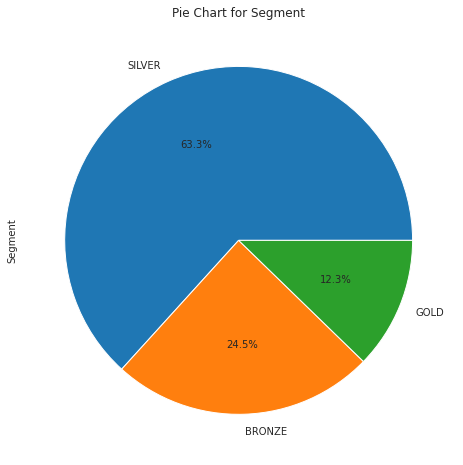

In [66]:
df_w['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Pie Chart for Segment')
plt.show()

In [67]:
df_w.Segment.value_counts()

SILVER    67401
BRONZE    26065
GOLD      13064
Name: Segment, dtype: int64

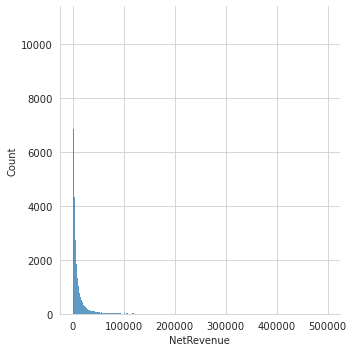

In [68]:
sns.displot(df['NetRevenue'])

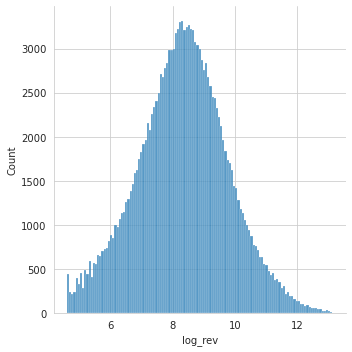

In [69]:
sns.displot(df['log_rev'])

## Elbow Method

In [70]:
rev_data_w = df_w['log_rev']

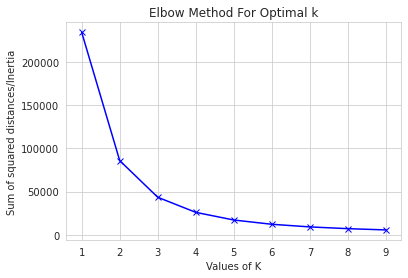

In [71]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_data_w.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [72]:
model_w = KMeans(n_clusters=4, random_state=42, max_iter=100000, init='random')

In [73]:
model_w.fit(rev_data_w.values.reshape(-1, 1))
preds_w = model_w.predict(rev_data_w.values.reshape(-1, 1))

In [74]:
rev_data_w = pd.concat([rev_data_w, pd.DataFrame({'preds':preds_w}, index=rev_data_w.index)], axis=1)

In [75]:
result_w = pd.merge(rev_data_w, df_w[['Segment', 'NetRevenue']], how='inner', left_index=True, right_index=True)
result_w['preds'] = result_w['preds'].astype('category')

In [76]:
result_w.head(1)

,log_rev,preds,Segment,NetRevenue
0,4.60517,2,SILVER,100.0


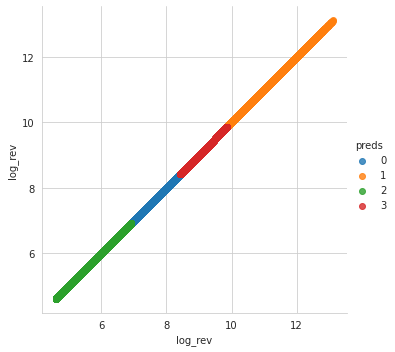

In [77]:
sns.lmplot(x='log_rev', y='log_rev', data=result_w, hue='preds', fit_reg=False)

In [78]:
result_w['rank'] = result_w['preds'].apply(lambda x: 
                                      0 if x==2 # green
                                      else 1 if x==0 # blue
                                      else 2 if x==3 # red 
                                      else 3) # orange

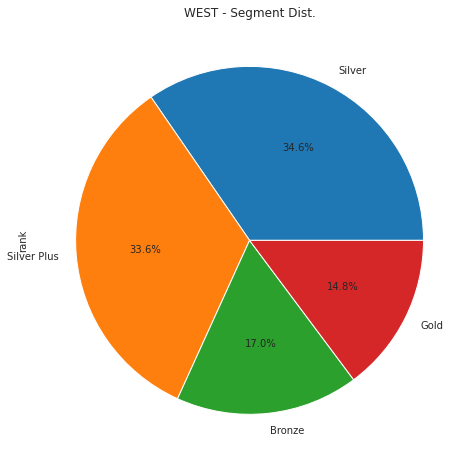

In [110]:
result_w["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('WEST - Segment Dist.')
plt.show()

In [111]:
result_w["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts()

Silver         36850
Silver Plus    35810
Bronze         18115
Gold           15755
Name: rank, dtype: int64

## Decision Points of WEST

In [83]:
d_w = DecisionTreeClassifier(random_state=42)
d_w.fit(result_w['NetRevenue'].values.reshape(-1,1), result_w['rank'])
d_preds_w = d_w.predict(result_w['NetRevenue'].values.reshape(-1,1))
d_text_w = tree.export_text(d_w)
print(d_text_w)

|--- feature_0 <= 4499.95
|   |--- feature_0 <= 1014.92
|   |   |--- class: 0
|   |--- feature_0 >  1014.92
|   |   |--- class: 1
|--- feature_0 >  4499.95
|   |--- feature_0 <= 19366.56
|   |   |--- class: 2
|   |--- feature_0 >  19366.56
|   |   |--- class: 3



## Comparison Matrix of WEST

In [86]:
df_new_w = pd.merge(df_w[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','log_rev']], 
                  result_w[['Segment', 'rank']], 
                  how='inner', left_index=True, right_index=True)

rank         0      1      2     3
Segment                           
BRONZE    6486  14116   5267   196
GOLD       282    934   3554  8294
SILVER   11347  21800  26989  7265


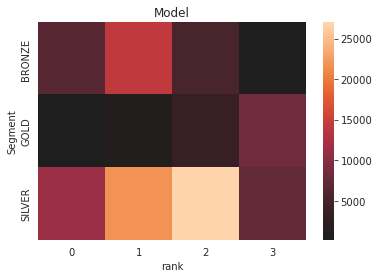

In [87]:
d1_w = pd.pivot_table(data=df_new_w
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

d1_w = d1_w[sorted(d1_w.columns)]
print(d1_w)
sns.heatmap(d1_w, center=0).set_title('Model')
plt.show()

### Save as CSV

In [ ]:
final_df_w = df_new_w[['OutletNumber','Name','OutletAddress2','SubTradeChannel','SalesCenter','NetRevenue','rank']]

In [ ]:
# ismi değiştir
final_df_w.to_csv('results_clus4_20211005.csv', sep='|')

## EAST

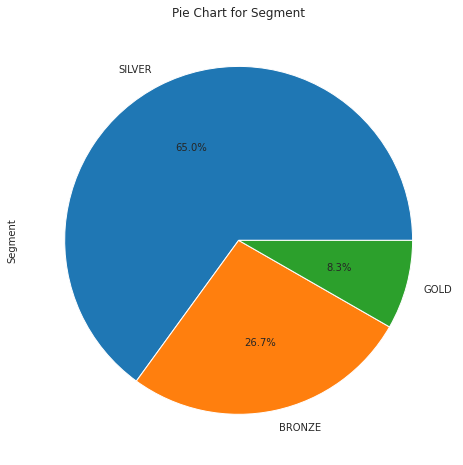

In [88]:
df_e['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Pie Chart for Segment')
plt.show()

In [89]:
df_e.Segment.value_counts()

SILVER    34232
BRONZE    14069
GOLD       4366
Name: Segment, dtype: int64

In [90]:
rev_data_e = df_e['log_rev']

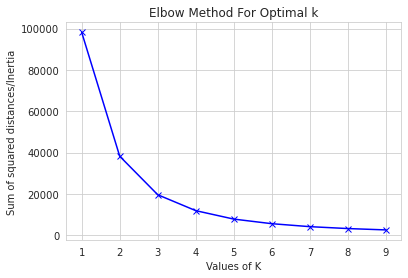

In [91]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_data_e.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [92]:
model_e = KMeans(n_clusters=4, random_state=42, max_iter=100000, init='random')

In [93]:
model_e.fit(rev_data_e.values.reshape(-1, 1))
preds_e = model_e.predict(rev_data_e.values.reshape(-1, 1))

In [94]:
rev_data_e = pd.concat([rev_data_e, pd.DataFrame({'preds':preds_e}, index=rev_data_e.index)], axis=1)

In [95]:
result_e = pd.merge(rev_data_e, df_e[['Segment', 'NetRevenue']], how='inner', left_index=True, right_index=True)
result_e['preds'] = result_e['preds'].astype('category')

In [96]:
result_e.head(1)

,log_rev,preds,Segment,NetRevenue
0,4.606569,1,BRONZE,100.14


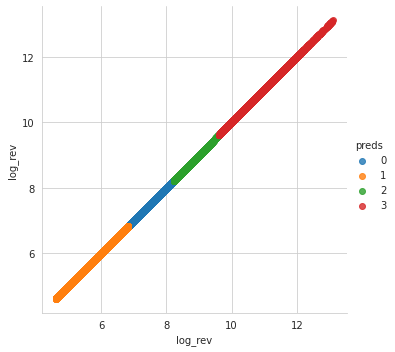

In [97]:
sns.lmplot(x='log_rev', y='log_rev', data=result_e, hue='preds', fit_reg=False)

In [98]:
result_e['rank'] = result_e['preds'].apply(lambda x: 
                                           0 if x==1 # orange
                                           else 1 if x==0 # blue
                                           else 2 if x==2 # green
                                           else 3) # red

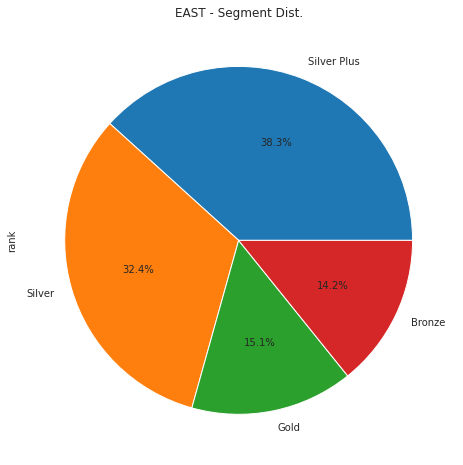

In [112]:
result_e["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('EAST - Segment Dist.')
plt.show()

In [113]:
result_e["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts()

Silver Plus    20161
Silver         17056
Gold            7962
Bronze          7488
Name: rank, dtype: int64

## Decision Points of EAST

In [101]:
d_e = DecisionTreeClassifier(random_state=42)
d_e.fit(result_e['NetRevenue'].values.reshape(-1,1), result_e['rank'])
d_preds_e = d_e.predict(result_e['NetRevenue'].values.reshape(-1,1))
d_text_e = tree.export_text(d_e)
print(d_text_e)

|--- feature_0 <= 3705.72
|   |--- feature_0 <= 916.69
|   |   |--- class: 0
|   |--- feature_0 >  916.69
|   |   |--- class: 1
|--- feature_0 >  3705.72
|   |--- feature_0 <= 14729.73
|   |   |--- class: 2
|   |--- feature_0 >  14729.73
|   |   |--- class: 3



## Comparison Matrix of EAST

In [104]:
df_new_e = pd.merge(df_e[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','log_rev']], 
                  result_e[['Segment', 'rank']], 
                  how='inner', left_index=True, right_index=True)

rank        0      1      2     3
Segment                          
BRONZE   2790   6752   4311   216
GOLD      121    271    966  3008
SILVER   4577  10033  14884  4738


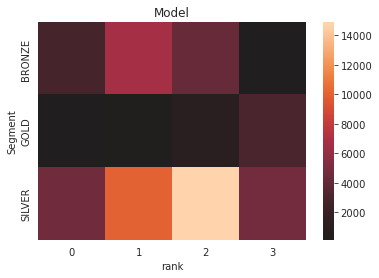

In [105]:
d1_e = pd.pivot_table(data=df_new_e
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

d1_e = d1_e[sorted(d1_e.columns)]
print(d1_e)
sns.heatmap(d1_e, center=0).set_title('Model')
plt.show()

### Save as CSV

In [ ]:
final_df_e = df_new_e[['OutletNumber','Name','OutletAddress2','SubTradeChannel','SalesCenter','NetRevenue','rank']]

In [ ]:
# ismi değiştir
final_df_e.to_csv('results_clus4_20211005.csv', sep='|')

<h1><center>Conclusion (During Covid) </center></h1>

<img src="cov0.png" width="800" align="center"/>

<img src="cov1.png" width="800" align="center"/>

<img src="cov2.png" width="800" align="center"/>

&nbsp;

<img src="cov3.png" width="800" align="center"/>

## - DURING COVID - 

### How is the segment distribution in the "West" after clustering throughout Turkey?

In [119]:
# WEST
df_west = df_new.loc[df_new['SalesCenter'].isin(['13: ISTANBUL COLD DRINK',
                                                 '50: BURSA SCM',
                                                 '90: IZMIR SCM',
                                                 '30: ANKARA SCM',
                                                 '71: HOD',
                                                 '20: ANTALYA SCM',
                                                 '93: LAM HOTELS SCM',
                                                 '12: ISTANBUL HOME CHANNE'])]

rank         0      1      2     3
Segment                           
BRONZE    6408  13725   5690   242
GOLD       279    886   3192  8707
SILVER   11227  20957  26874  8343


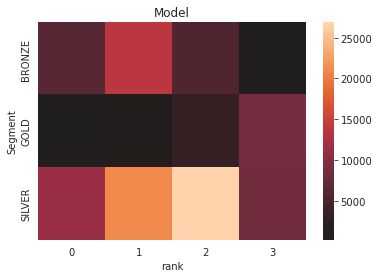

In [120]:
m1 = pd.pivot_table(data=df_west
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

m1 = m1[sorted(m1.columns)]
print(m1)
sns.heatmap(m1, center=0).set_title('Model')
plt.show()

### How is the segment distribution in the "East" after clustering throughout Turkey?

In [121]:
# EAST
df_east = df_new.loc[df_new['SalesCenter'].isin(['70: ELAZIG SCM','60: MERSIN SCM','40: KARADENIZ SCM','65: AT WORK'])]

rank        0      1      2     3
Segment                          
BRONZE   3045   7399   3502   123
GOLD      134    303   1192  2737
SILVER   4978  11227  14495  3532


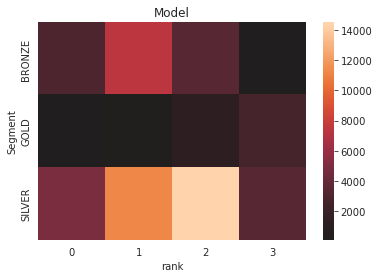

In [122]:
m2 = pd.pivot_table(data=df_east
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

m2 = m2[sorted(m2.columns)]
print(m2)
sns.heatmap(m2, center=0).set_title('Model')
plt.show()